In [121]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [122]:
def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)


# def softmax(x):
#     """
#     Compute softmax values for each sets of scores in x.
    
#     Rows are scores for each class. 
#     Columns are predictions (samples).
#     """
#     scoreMatExp = np.exp(np.asarray(x))
#     return scoreMatExp / scoreMatExp.sum(0)

In [123]:
# data = pd.read_csv('./data/dan_table.csv')
data = pd.read_csv('./data/rachel_table.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session'])

data = data[(data['RecordLoc'] != 5) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [205]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        trial_df = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(trial_df.IpsLeverPress.values) >  sum(trial_df.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(trial_df.CSplus.values) >  sum(trial_df.CSneg.values):
            reward = 1
        else:
            reward = 0

        sess = np.unique(trial_df['Session'])[0]
        recordloc = np.unique(trial_df['RecordLoc'])[0]
        data_t.append([ mouse_id - 1, t_i, action, reward, t , sess, recordloc]) #  lever_press])


    
    
        

In [206]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'TrialStart',
                                             'Session', 'RecordLoc'))
                


In [163]:
# df_trials = df_trials.drop(df_trials[(df_trials['MouseID'] == 5) & (df_trials['Session'] == 3)].index)

# _df_trials = df_trials.drop(df_trials[(df_trials['MouseID'] == 9)].index)




In [209]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  

# NT_all[0] = NT_all[0] - 2
# r[0,:-2] = r[0, 2:]
# c[0,:-2] = c[0, 2:]
standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [211]:
# fit = pystan.stan(file = 'stan/qlearning2_checkfit.stan',data=standata, iter=1000, warmup=250, chains=4, 
#                   control=dict(adapt_delta = 0.9999))

fit = sm.sampling( data=standata, iter=1000, warmup=250, chains=4, 
                 seed = 4, control=dict(adapt_delta = 0.9999))

In [212]:
stan_utility.check_treedepth(fit); stan_utility.check_energy(fit); stan_utility.check_div(fit)
print(fit)

0 of 3000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 3000 iterations ended with a divergence (0.0%)
Inference for Stan model: anon_model_55a0325f434bfe80b444861f9d5cf83f.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
betam        1.48    0.05   0.18    1.1   1.37   1.48    1.6   1.84     15   1.06
alpham       0.16     0.1   0.23  -0.44   0.08   0.21    0.3   0.51      5   1.28
betasd       0.55  3.7e-3   0.14   0.34   0.45   0.53   0.63   0.89   1488   1.01
alphasd      0.56    0.19   0.33   0.22   0.33   0.42   0.73   1.37      3   2.11
betas[0]     2.18  1.3e-3   0.07   2.04   2.13   2.18   2.23   2.32   3000    1.0
betas[1]     1.77  1.3e-3   0.07   1.63   1.73   1.77   1.82   1.91   3000    1.0
betas[2]     1.19  1.2e-3   0.06   1.08   1.15   1.19   1.23   1.31   2648  

In [233]:
## Save summary file.
summary = fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
summary.to_csv(os.path.join('data/', 'summary_full_seed4.csv'))

# Save contents of StanFit.
extract = fit.extract()
for k, v in standata.items(): extract[k] = v
with open(os.path.join('data/' 'StanFit_full_seed4.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

In [234]:
sm = pystan.StanModel(file = 'stan/qlearning2_checkfit.stan')

fit = sm.sampling(data=standata, iter=1000, warmup=250, chains=4,
                  control=dict(adapt_delta = 0.9999))

stan_utility.check_treedepth(fit); stan_utility.check_energy(fit); stan_utility.check_div(fit)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55a0325f434bfe80b444861f9d5cf83f NOW.


KeyboardInterrupt: 

In [56]:
# ## Save summary file.
# summary = fit.summary()
# summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
# summary.to_csv(os.path.join('data/', 'summary.csv'))

# # Save contents of StanFit.
# extract = fit.extract()
# for k, v in standata.items(): extract[k] = v
# with open(os.path.join('data/' 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

In [248]:
import pickle
extract = pickle.load( open( "data/m1_small_seed4/StanFit_full_seed4.pickle", "rb" ) )
summary = pd.DataFrame.from_csv("data/m1_small_seed4/summary_full_seed4.csv")

In [249]:
summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
betam,1.449262,0.003027,0.165809,1.121782,1.343312,1.447177,1.554019,1.781253,3000.0,1.000244
alpham,0.237820,0.002829,0.121722,0.001358,0.160679,0.238738,0.314304,0.481700,1851.0,1.001173
betasd,0.564644,0.002539,0.139049,0.363916,0.467419,0.541790,0.635899,0.921411,3000.0,0.999672
alphasd,0.387024,0.002856,0.115255,0.216467,0.306602,0.368576,0.449728,0.659245,1629.0,1.003426
betas[0],2.179053,0.001493,0.074597,2.034552,2.128997,2.179372,2.230316,2.324405,2497.0,0.999948
betas[1],1.773214,0.001321,0.072332,1.632982,1.724179,1.773858,1.820900,1.919905,3000.0,0.999512
betas[2],1.187649,0.001127,0.061725,1.068088,1.145492,1.187450,1.228110,1.315083,3000.0,0.999285
betas[3],1.521876,0.001101,0.060293,1.406182,1.479246,1.522128,1.562994,1.642095,3000.0,0.999452
betas[4],0.761730,0.001183,0.064812,0.637293,0.717062,0.761891,0.805158,0.888741,3000.0,1.000823
betas[5],0.728782,0.001306,0.065176,0.600475,0.684802,0.727696,0.772887,0.860573,2490.0,0.999829


In [199]:
fit

Inference for Stan model: anon_model_55a0325f434bfe80b444861f9d5cf83f.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
betam         1.2    0.18   0.39   0.27   0.94   1.31   1.48   1.76      5    1.3
alpham      -0.02    0.17   0.34  -0.78  -0.25   0.09   0.24   0.44      4   1.41
betasd       1.01    0.31   0.53   0.39   0.55   0.91   1.37   2.27      3   1.81
alphasd      0.76    0.26   0.45   0.24   0.36   0.69   1.08   1.69      3   2.04
betas[0]     1.13    1.31   1.85  -2.64   0.51   2.15   2.22   2.32      2   7.76
betas[1]     1.78  1.3e-3   0.07   1.64   1.73   1.77   1.83   1.92   3000    1.0
betas[2]     0.43    0.97   1.37  -2.75   0.37   1.16   1.22    1.3      2   4.13
betas[3]     1.52  1.1e-3   0.06    1.4   1.48   1.52   1.56   1.64   3000   1.01
betas[4]    -0.16    0.66   0.94  -1.46  -1.08   0.16   0.76   0.87      2 

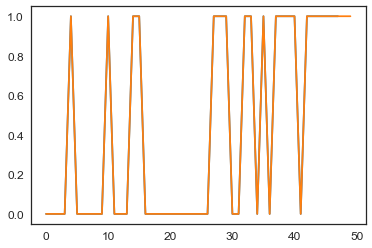

In [97]:
plt.plot(r[0,2:50])
plt.plot(extract['r'][0,:50])

In [101]:
np.sum(c[0, 2:] - extract['c'][0,:-2] )



0

In [8]:
%%time 
# get the predictions: 
N_samples = np.shape(extract['betas'])[0]


Q_i = np.zeros((N_samples, NS, (NT + 1)), float)
Q_c = np.zeros((N_samples, NS, (NT + 1)), float)
delta = np.zeros((N_samples, NS, NT), float)

for s in np.arange(NS):

    for t in np.arange(extract['NT_all'][s]):

        r_i = extract['r'][s, t]
        c_i = extract['c'][s, t]

        if c_i == 0: # contra choice
            Q_choice = Q_c; 
            Q_other = Q_i; 
        elif c_i == 1: # ipsa choice
            Q_choice = Q_i; 
            Q_other = Q_c; 
            
        delta[:, s, t] = r_i - Q_choice[:, s, t]
        
        
        # Q of the choice is updated, the other one is not. 
        Q_choice[:, s, t + 1] = Q_choice[:, s, t] + phi_approx(extract['alphas'][:,s]) * delta[:, s, t]
        Q_other[:, s, t + 1] = Q_other[: ,s, t]
        




_Q_i = np.mean(Q_i, 0)
_Q_c = np.mean(Q_c, 0)

CPU times: user 28.7 s, sys: 6.28 s, total: 35 s
Wall time: 40.6 s


In [9]:
%%time
prob_ipsa = np.zeros((N_samples, NS, NT))
prob_contra = np.zeros((N_samples, NS, NT))



for s in np.arange(NS):
    betas_i = extract['betas'][:,s]

    prob_ipsa[:, s, :NT_all[s]] =(np.exp(betas_i[:, np.newaxis]  * Q_i[:, s, :NT_all[s]]) 
                                 / (np.exp(betas_i[:, np.newaxis]   * Q_c[:, s,:NT_all[s]]) + 
                                    np.exp(betas_i[:, np.newaxis]  * Q_i[:, s,:NT_all[s]])))
    
    prob_contra[:, s, :NT_all[s]] =(np.exp(betas_i[:, np.newaxis] *  Q_c[:, s, :NT_all[s]]) 
                                 / (np.exp(betas_i[:, np.newaxis] *  Q_c[:, s,:NT_all[s]]) + 
                                    np.exp(betas_i[:, np.newaxis]  * Q_i[:, s,:NT_all[s]])))
    

_prob_ipsa = np.mean(prob_ipsa, axis = 0)
_prob_contra = np.mean(prob_contra, axis = 0)

CPU times: user 14 s, sys: 10.8 s, total: 24.8 s
Wall time: 30 s


In [10]:
_prob_choice = np.zeros((NS, NT))

_prob_choice[c == 0] = _prob_contra[c == 0]
_prob_choice[c == 1] = _prob_ipsa[c == 1]
        

In [11]:
# calculating the pseudo R^2, as defined as: 
# psuedo_r = 1 - log(L_c) / log(L_null)
# for L_null, we will define as: sum(log(total_ipsi/total_trials)) + sum(log(total_contra/total_trials))

psuedo_r = []
for s in np.arange(NS):

    data_small = df_trials[df_trials['MouseID'] == s]
    num_ipsa_i = len(data_small[data_small['Action'] == "Ips"])
    num_contra_i = len(data_small[data_small['Action'] == "Con"])

    log_L_null = np.log(0.5) * NT_all[s]
#     (np.log(num_ipsa_i/NT_all[s])) * num_ipsa_i + (np.log(num_contra_i/NT_all[s])) * num_contra_i

    log_L_c = sum(np.log(_prob_choice[s, :NT_all[s]]))
    

    psuedo_r.append(1 - (log_L_c / log_L_null))
    

# psuedo-r needs 1. 0.5 until I get the b0 in 
# the prob_ipsa should be prob_choice, not prob_ipsa 

In [12]:
psuedo_r

[0.23240674515566684,
 0.16206812812064064,
 0.088361106266638845,
 0.14987018108276606,
 0.041754443245826112,
 0.036427641632915453,
 0.21168087024654814,
 0.16402156651479727,
 0.086523879833013795,
 0.049997310358773972,
 0.14134013612596175,
 0.10030866571132502]

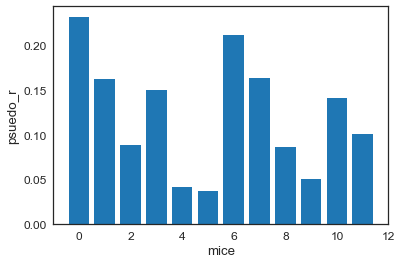

In [106]:
plt.bar(np.arange(NS), psuedo_r)
plt.ylabel('psuedo_r')
plt.xlabel('mice')

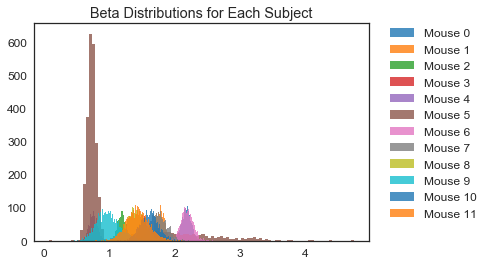

In [14]:
for s in np.arange(NS):
    plt.hist(extract['betas'][:,s], 100, alpha = 0.8, label = 'Mouse {:d}'.format(s))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Beta Distributions for Each Subject')

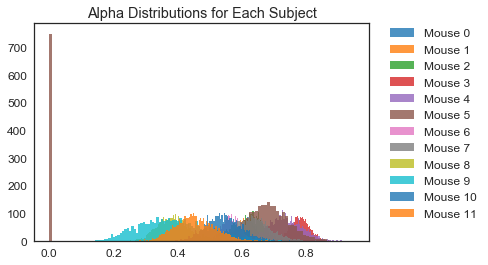

In [15]:
for s in np.arange(NS):
    plt.hist(phi_approx(extract['alphas'][:,s]), 100, alpha = 0.8, label = 'Mouse {:d}'.format(s))

    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Alpha Distributions for Each Subject')

(array([  750.,     0.,     0.,     0.,     0.,    63.,   687.,  1167.,
          314.,    19.]),
 array([  1.33466009e-04,   9.32104499e-02,   1.86287434e-01,
          2.79364418e-01,   3.72441401e-01,   4.65518385e-01,
          5.58595369e-01,   6.51672353e-01,   7.44749337e-01,
          8.37826321e-01,   9.30903305e-01]),
 <a list of 10 Patch objects>)

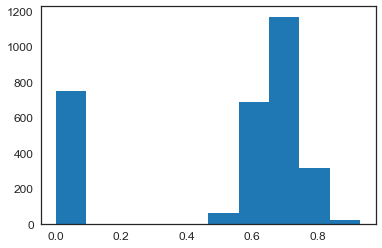

In [18]:
plt.hist(phi_approx(extract['alphas'][:,5]))

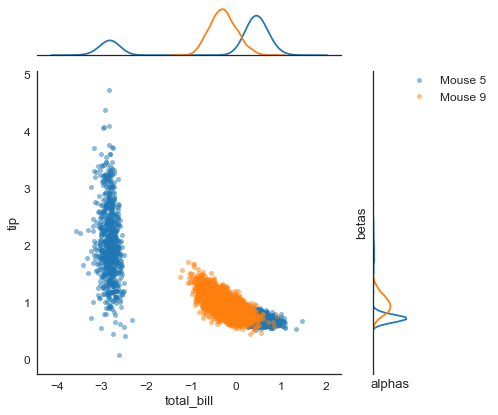

In [20]:
tips = sns.load_dataset("tips")

alphas = extract['alphas']
betas = extract['betas']
g = sns.JointGrid("total_bill", "tip", tips) # FIX THIS 

for s in [5, 9]: #np.arange():
    
    sns.kdeplot(alphas[:,s], ax=g.ax_marg_x, legend=False)
    sns.kdeplot(betas[:,s], ax=g.ax_marg_y, vertical=True, legend = False) 
    g.ax_joint.plot(alphas[:,s], betas[:,s], 'o', ms=5, alpha = 0.5, label = 'Mouse {:d}'.format(s))
    
plt.xlabel('alphas')
plt.ylabel('betas')
g.ax_joint.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
plt.tight_layout()


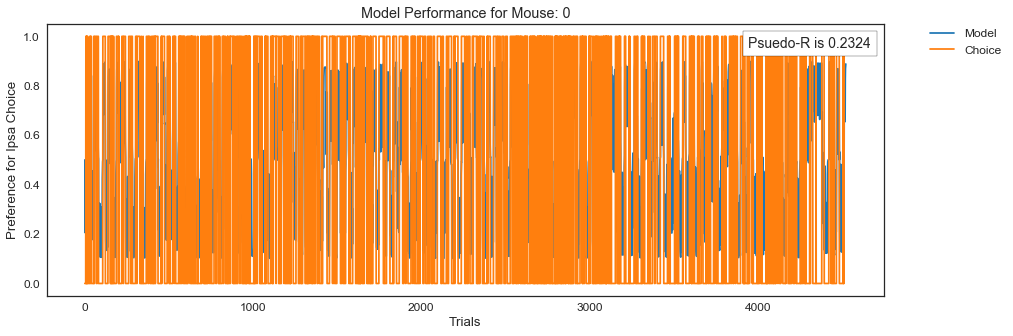

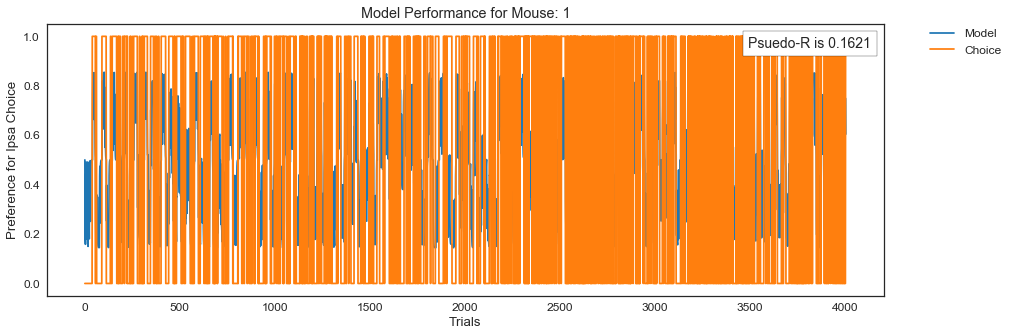

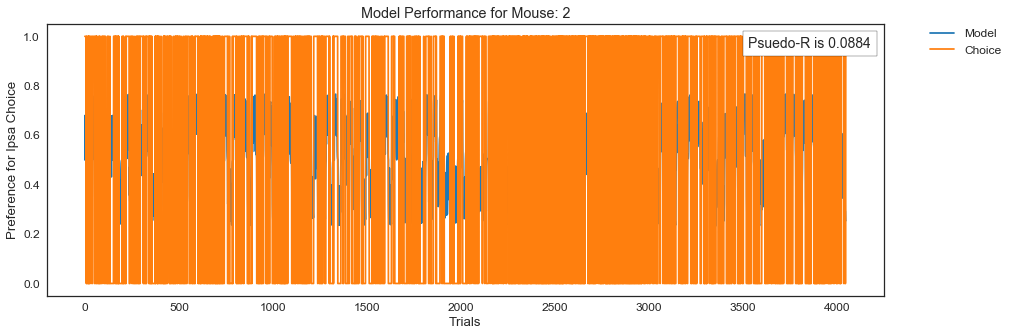

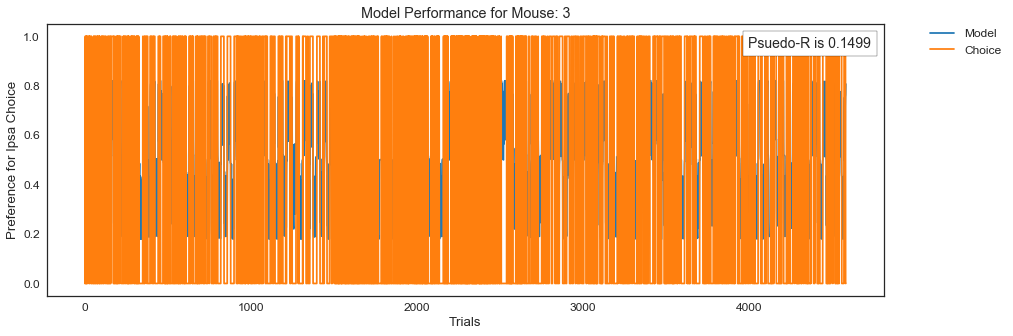

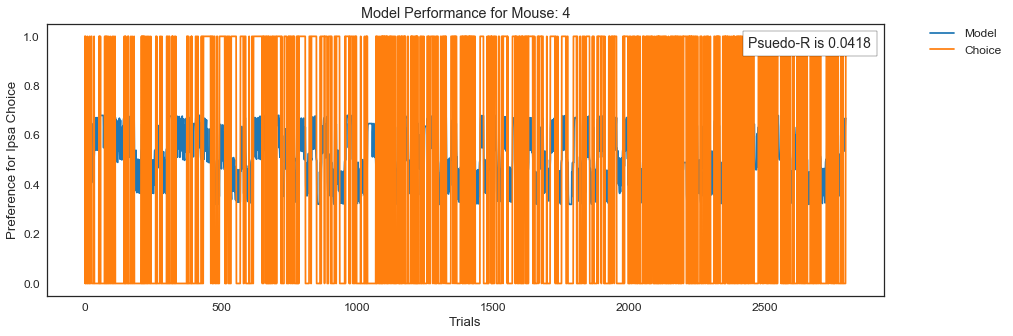

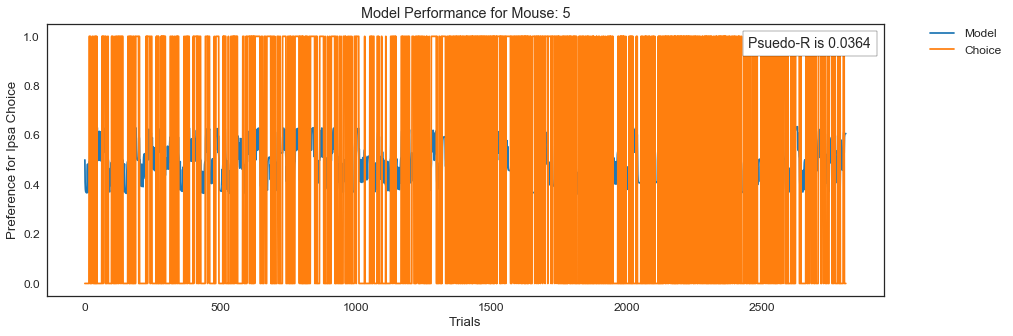

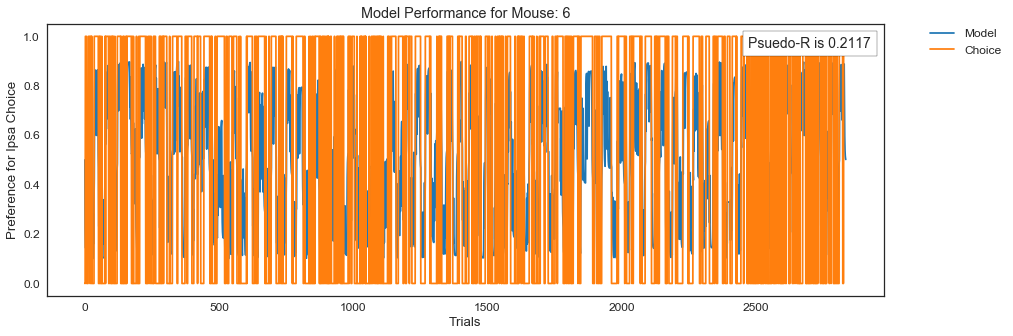

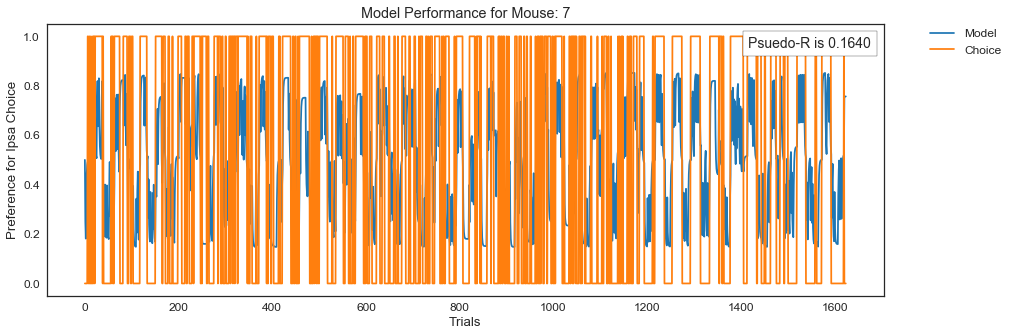

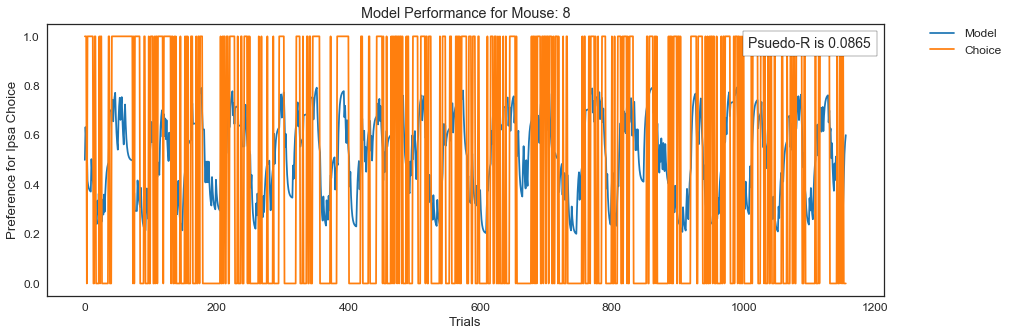

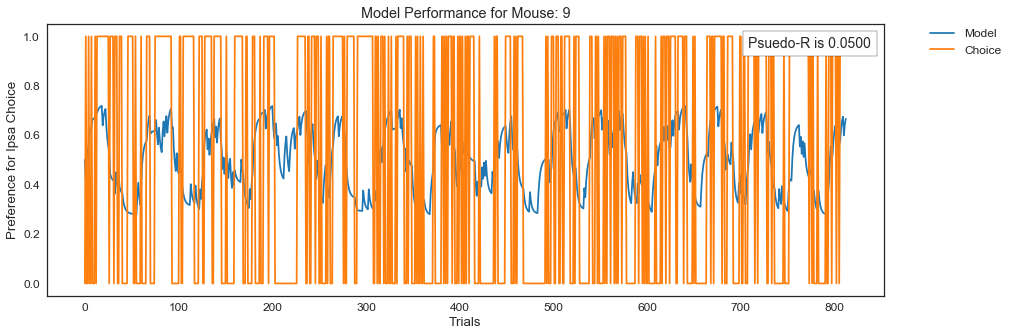

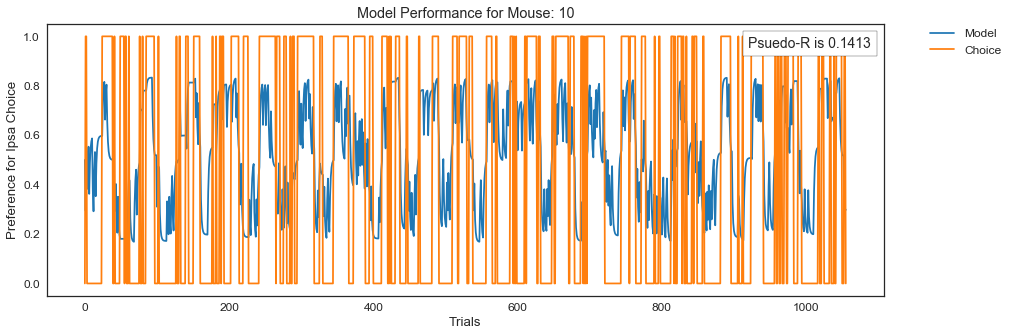

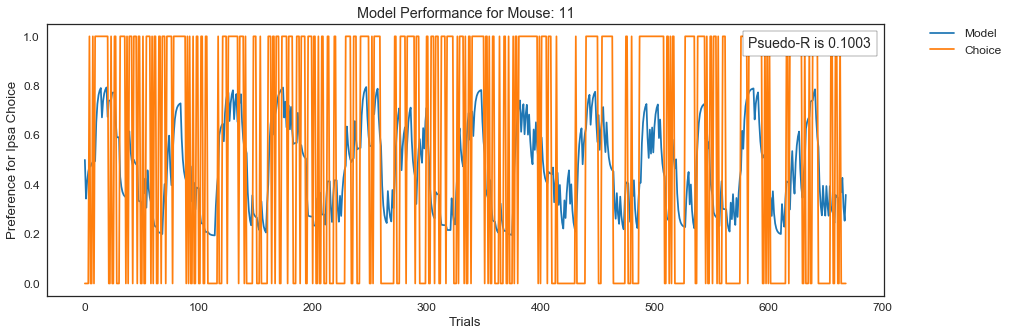

In [120]:

for s in np.arange(NS):

    fig = plt.figure(figsize= (15, 5))
    plt.plot(np.mean(prob_ipsa[:, s,:NT_all[s]], axis = 0), label = 'Model')
#     plt.plot(_Q_i[s, :NT_all[s]], label = 'Q_ipsa')
#     plt.plot(_Q_c[s, :NT_all[s]], label = 'Q_contra')
    plt.plot(c[s,:NT_all[s]], label = 'Choice')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Trials')
    plt.ylabel('Preference for Ipsa Choice')
    plt.title('Model Performance for Mouse: {:d}'.format(s))
    p_corr = AnchoredText('Psuedo-R is {:.4f}'
                          .format(psuedo_r[s]),
                      prop=dict(size=14), frameon=True,
                      loc=1,
                      )
    
    axes = plt.gca()
    axes.add_artist(p_corr)
    plt.savefig('data/plots/{:d}_model_perf.png'.format(s))
    
    

## debug code

In [ ]:
mini = {'NS':3, 'NT':4, 'NT_all':[1, 2, 4], 
                 'r':r[:3, :4], 'c':c[:3,:4]}
debug = sm.sampling(data=mini, iter=2, warmup=1, chains=1)
extract = debug.extract()
for k, v in mini.items(): extract[k] = v

extract['prob_c']
extract['c_hat']